In [1]:
from snowflake.snowpark import Session
#from snowflake.core import Root
import toml 

toml_file_path = ('configure.toml')
with open(toml_file_path,'r') as file:
    config_data = toml.load(file)
## read from toml file
user = config_data['RPEGU_AIML']['user']
pwd = config_data['RPEGU_AIML']['password']
account = config_data['RPEGU_AIML']['account']
role = config_data['RPEGU_AIML']['role']



connection_parameters = {
 "account": account,
 "user": user,
"password": pwd,
"role": role,  # optional
 }  

session = Session.builder.configs(connection_parameters).create()


In [2]:


session.sql("use warehouse DS_W").collect()
session.sql("use database  ML_MODELS").collect()
session.sql("use schema ML_MODELS.DS").collect()

from snowflake.snowpark.version import VERSION
import snowflake.snowpark.functions as F


snowflake_environment = session.sql('SELECT current_user(), current_version()').collect()
snowpark_version = VERSION

# Current Environment Details
print('\nConnection Established with the following parameters:')
print('User                        : {}'.format(snowflake_environment[0][0]))
print('Role                        : {}'.format(session.get_current_role()))
print('Database                    : {}'.format(session.get_current_database()))
print('Schema                      : {}'.format(session.get_current_schema()))
print('Warehouse                   : {}'.format(session.get_current_warehouse()))
print('Snowflake version           : {}'.format(snowflake_environment[0][1]))
print('Snowpark for Python version : {}.{}.{}'.format(snowpark_version[0],snowpark_version[1],snowpark_version[2]))


Connection Established with the following parameters:
User                        : RPEGU
Role                        : "ACCOUNTADMIN"
Database                    : "ML_MODELS"
Schema                      : "DS"
Warehouse                   : "DS_W"
Snowflake version           : 8.43.0
Snowpark for Python version : 1.23.0


In [13]:
conda list snowflake

# packages in environment at /Users/rpegu/opt/anaconda3/envs/py39:
#
# Name                    Version                   Build  Channel
snowflake-connector-python 3.12.3          py39h6d0c2b6_100    https://repo.anaconda.com/pkgs/snowflake
snowflake-ml-python       1.7.1                    pypy_0    https://raw.githubusercontent.com/snowflakedb/snowflake-ml-python/conda/releases
snowflake-snowpark-python 1.23.0          py39hecd8cb5_100    https://repo.anaconda.com/pkgs/snowflake

Note: you may need to restart the kernel to use updated packages.


## get the sample data

In [3]:
df_banknote = session.table("BANKNOTE_AUTHENTICATION")
df_banknote.show()



--------------------------------------------------------------------------------------------
|"VARIANCE_WAVELET"  |"SKEWNESS_WAVELET"  |"CURTOSIS_WAVELET"  |"IMAGE_ENTROPY"  |"CLASS"  |
--------------------------------------------------------------------------------------------
|3.6216000           |8.6661              |-2.80730000         |-0.4469900       |0        |
|4.5459000           |8.1674              |-2.45860000         |-1.4621000       |0        |
|3.8660000           |-2.6383             |1.92420000          |0.1064500        |0        |
|3.4566000           |9.5228              |-4.01120000         |-3.5944000       |0        |
|0.3292400           |-4.4552             |4.57180000          |-0.9888000       |0        |
|4.3684000           |9.6718              |-3.96060000         |-3.1625000       |0        |
|3.5912000           |3.0129              |0.72888000          |0.5642100        |0        |
|2.0922000           |-6.81               |8.46360000          |-0.602

In [4]:
df_banknote.dtypes

[('VARIANCE_WAVELET', 'decimal(38,7)'),
 ('SKEWNESS_WAVELET', 'string(16777216)'),
 ('CURTOSIS_WAVELET', 'decimal(38,8)'),
 ('IMAGE_ENTROPY', 'decimal(38,7)'),
 ('CLASS', 'bigint')]

In [5]:
new_col = df_banknote.col("SKEWNESS_WAVELET").cast("float")
df_banknote = df_banknote.with_column('SKEWNESS_WAVELET_NEW', new_col)
df_banknote.show()
df_banknote= df_banknote.drop("SKEWNESS_WAVELET")
df_banknote.show()

---------------------------------------------------------------------------------------------------------------------
|"VARIANCE_WAVELET"  |"SKEWNESS_WAVELET"  |"CURTOSIS_WAVELET"  |"IMAGE_ENTROPY"  |"CLASS"  |"SKEWNESS_WAVELET_NEW"  |
---------------------------------------------------------------------------------------------------------------------
|3.6216000           |8.6661              |-2.80730000         |-0.4469900       |0        |8.6661                  |
|4.5459000           |8.1674              |-2.45860000         |-1.4621000       |0        |8.1674                  |
|3.8660000           |-2.6383             |1.92420000          |0.1064500        |0        |-2.6383                 |
|3.4566000           |9.5228              |-4.01120000         |-3.5944000       |0        |9.5228                  |
|0.3292400           |-4.4552             |4.57180000          |-0.9888000       |0        |-4.4552                 |
|4.3684000           |9.6718              |-3.96060000  

In [6]:
df_banknote.show()
FEATURE_COLUMNS = ['VARIANCE_WAVELET', 'SKEWNESS_WAVELET_NEW', 'CURTOSIS_WAVELET', 'IMAGE_ENTROPY']
LABEL_COLUMN =['CLASS']
df_banknote.dtypes

------------------------------------------------------------------------------------------------
|"VARIANCE_WAVELET"  |"CURTOSIS_WAVELET"  |"IMAGE_ENTROPY"  |"CLASS"  |"SKEWNESS_WAVELET_NEW"  |
------------------------------------------------------------------------------------------------
|3.6216000           |-2.80730000         |-0.4469900       |0        |8.6661                  |
|4.5459000           |-2.45860000         |-1.4621000       |0        |8.1674                  |
|3.8660000           |1.92420000          |0.1064500        |0        |-2.6383                 |
|3.4566000           |-4.01120000         |-3.5944000       |0        |9.5228                  |
|0.3292400           |4.57180000          |-0.9888000       |0        |-4.4552                 |
|4.3684000           |-3.96060000         |-3.1625000       |0        |9.6718                  |
|3.5912000           |0.72888000          |0.5642100        |0        |3.0129                  |
|2.0922000           |8.463600

[('VARIANCE_WAVELET', 'decimal(38,7)'),
 ('CURTOSIS_WAVELET', 'decimal(38,8)'),
 ('IMAGE_ENTROPY', 'decimal(38,7)'),
 ('CLASS', 'bigint'),
 ('SKEWNESS_WAVELET_NEW', 'double')]

## CORRELATION

In [9]:
from snowflake.ml.modeling.metrics.correlation import correlation
df_1= df_banknote.select(*FEATURE_COLUMNS)
coor_matrix = correlation(df = df_1,)


In [37]:
print(coor_matrix )
train_df, df_test = df_banknote.random_split(weights=[0.8, 0.2], seed=62)

                      VARIANCE_WAVELET  SKEWNESS_WAVELET_NEW  \
VARIANCE_WAVELET              1.000000              0.264026   
SKEWNESS_WAVELET_NEW          0.264026              1.000000   
CURTOSIS_WAVELET             -0.380850             -0.786895   
IMAGE_ENTROPY                 0.276817             -0.526321   

                      CURTOSIS_WAVELET  IMAGE_ENTROPY  
VARIANCE_WAVELET             -0.380850       0.276817  
SKEWNESS_WAVELET_NEW         -0.786895      -0.526321  
CURTOSIS_WAVELET              1.000000       0.318841  
IMAGE_ENTROPY                 0.318841       1.000000  


# TRAINING MODEL (LIGHTGBM Model)

In [18]:
# make sure the lightgbm is installed in virtual enviroment first
from snowflake.ml.modeling.lightgbm import LGBMClassifier

# Split the data into train and test sets
train_df, df_test = df_banknote.random_split(weights=[0.8, 0.2], seed=62)

lgbclassifer  = LGBMClassifier(
    input_cols = FEATURE_COLUMNS,
    label_cols = LABEL_COLUMN,
    output_cols ='PREDICTION'
)

lgbclassifer.fit(train_df)


/Users/rpegu/opt/anaconda3/envs/py39/lib/python3.9/site-packages/snowflake/ml/modeling/_internal/snowpark_implementations/snowpark_trainer.py:531: UserWarning: Warning: The Decimal(38, 7) data type is being automatically converted to DoubleType in the Snowpark DataFrame. This automatic conversion may lead to potential precision loss and rounding errors. If you wish to prevent this conversion, you should manually perform the necessary data type conversion.
  dataset = snowpark_dataframe_utils.cast_snowpark_dataframe_column_types(self.dataset)
/Users/rpegu/opt/anaconda3/envs/py39/lib/python3.9/site-packages/snowflake/ml/modeling/_internal/snowpark_implementations/snowpark_trainer.py:531: UserWarning: Warning: The Decimal(38, 8) data type is being automatically converted to DoubleType in the Snowpark DataFrame. This automatic conversion may lead to potential precision loss and rounding errors. If you wish to prevent this conversion, you should manually perform the necessary data type conv

The fitted model can be retrieved as an XGB object 

In [19]:
lgbmodel_local = lgbclassifer.to_lightgbm()

### plot the feature importance


<Axes: >

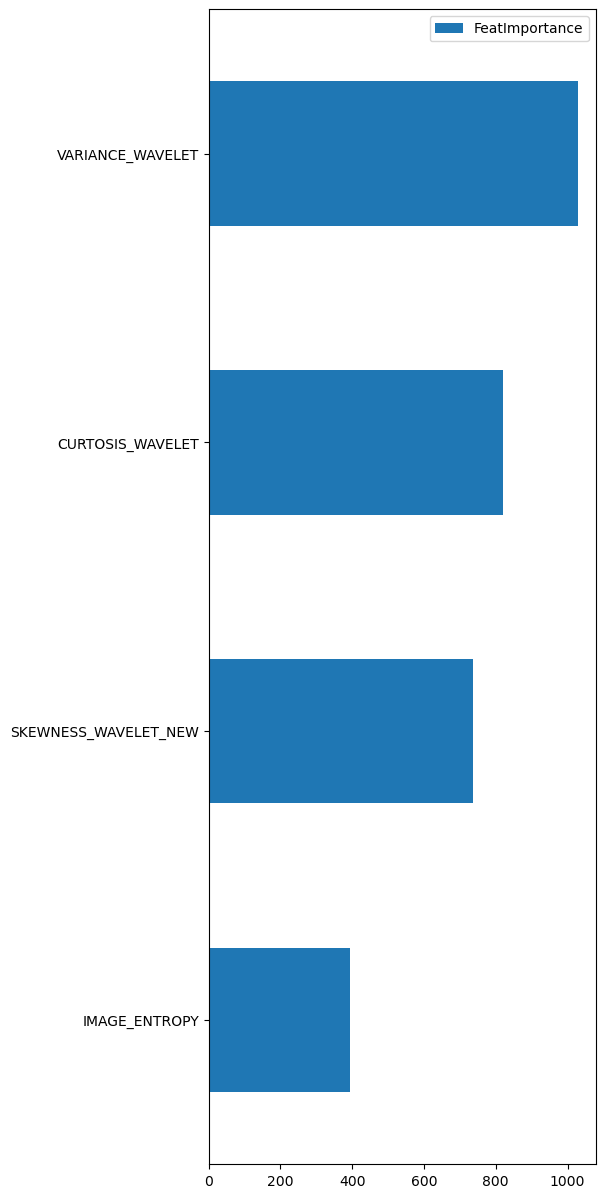

In [20]:
import pandas as pd
import matplotlib as plt
# Plot feature importance
feat_importance = pd.DataFrame(lgbmodel_local.feature_importances_,lgbmodel_local.feature_name_,columns=['FeatImportance'])
feat_importance.sort_values('FeatImportance').plot.barh(y='FeatImportance', figsize=(5,15))

# MODEL SCORING

In [23]:
scored_sdf = lgbclassifer.predict(df_test)
scored_sdf.write.save_as_table(table_name='BANKNOTE_LIGHTGBM_SCORED', mode='overwrite')


In [26]:

from snowflake.ml.modeling.metrics import *
print('Acccuracy:', accuracy_score(df=scored_sdf , y_true_col_names="CLASS", y_pred_col_names="PREDICTION"))
print('Precision:', precision_score(df=scored_sdf, y_true_col_names='CLASS', y_pred_col_names='PREDICTION'))
print('Recall:', recall_score(df=scored_sdf, y_true_col_names='CLASS', y_pred_col_names='PREDICTION'))
print('F1:', f1_score(df=scored_sdf, y_true_col_names='CLASS', y_pred_col_names='PREDICTION'))

# Obtaining and plotting a simple confusion matrix
cf_matrix = confusion_matrix(df=scored_sdf, y_true_col_name='CLASS', y_pred_col_name='PREDICTION')

#sns.heatmap(cf_matrix, annot=True, fmt='.0f', cmap='Blues')

Acccuracy: 0.996283
Precision: 1.0
Recall: 0.9918032786885246
F1: 0.9958847736625513


[[147.   0.]
 [  1. 121.]]


<Axes: >

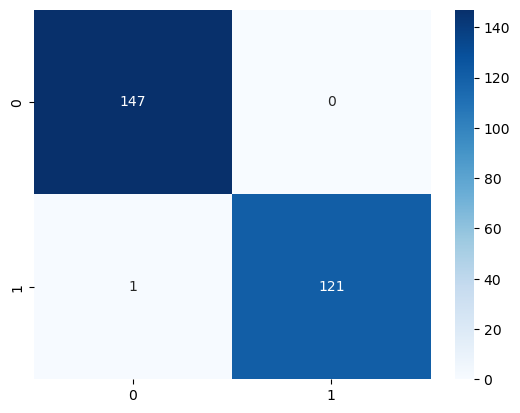

In [27]:
import seaborn as sns
print(cf_matrix)

sns.heatmap(cf_matrix, annot=True, fmt='.0f', cmap='Blues')


# Snowflake Model registry

In [13]:
from snowflake.ml.registry import Registry
session.sql("create schema if not exists ML_REGISTRY").collect()

db_name ='ML_MODELS'
schema_name ='ML_REGISTRY'

reg = Registry(session=session, database_name= db_name , schema_name=schema_name)

In [33]:
mv = reg.log_model(lgbclassifer,
                   model_name="lgbm_classification_model",
                   version_name="v1")

In [37]:
# Add evaluation metric
mv.options=options={"enable_explainability": True}
mv.sample_input_data=train_df

In [39]:
reg.show_models()

,created_on,name,model_type,database_name,schema_name,comment,owner,default_version_name,versions,aliases
0,2024-11-13 11:40:33.721000-08:00,LGBM_CLASSIFICATION_MODEL,USER_MODEL,ML_MODELS,ML_REGISTRY,None,ACCOUNTADMIN,V1,"[""V1""]","{""DEFAULT"":""V1"",""FIRST"":""V1"",""LAST"":""V1""}"


Now we can use model to perform inference

## Model Explainability

Another thing we may want to look at to better understand the predictions are explanations on what the model considers most impactful when generating the predictions. To generate these explanations, we'll use the built-in explainability function from Snowpark ML.

Under the hood, this function is based on Shapley values. During the training process, machine learning models infer relationships between inputs and outputs, and Shapley values are a way to attribute the output of a machine learning model to its input features. By considering all possible combinations of features, Shapley values measure the average marginal contribution of each feature to the model’s prediction. While computationally intensive, the insights gained from Shapley values are invaluable for model interpretability and debugging.

Let's calculate these explanations based on our optimal model now.

In [49]:
test_df_pred = mv.run(df_test,function_name ='predict')
test_df_pred.show()

/Users/rpegu/opt/anaconda3/envs/py39/lib/python3.9/site-packages/snowflake/ml/model/model_signature.py:491: UserWarning: Type DecimalType(38, 7) is being automatically converted to DOUBLE in the Snowpark DataFrame. This automatic conversion may lead to potential precision loss and rounding errors. If you wish to prevent this conversion, you should manually perform the necessary data type conversion.
  _validate_snowpark_type_feature(
/Users/rpegu/opt/anaconda3/envs/py39/lib/python3.9/site-packages/snowflake/ml/model/model_signature.py:491: UserWarning: Type DecimalType(38, 8) is being automatically converted to DOUBLE in the Snowpark DataFrame. This automatic conversion may lead to potential precision loss and rounding errors. If you wish to prevent this conversion, you should manually perform the necessary data type conversion.
  _validate_snowpark_type_feature(


---------------------------------------------------------------------------------------------------------------
|"CLASS"  |"VARIANCE_WAVELET"  |"SKEWNESS_WAVELET_NEW"  |"CURTOSIS_WAVELET"  |"IMAGE_ENTROPY"  |"PREDICTION"  |
---------------------------------------------------------------------------------------------------------------
|0        |3.4566              |9.5228                  |-4.0112             |-3.5944          |0             |
|0        |4.3684              |9.6718                  |-3.9606             |-3.1625          |0             |
|0        |3.5912              |3.0129                  |0.72888             |0.56421          |0             |
|0        |3.2032              |5.7588                  |-0.75345            |-0.61251         |0             |
|0        |1.8993              |7.6625                  |0.15394             |-3.1108          |0             |
|0        |3.404               |8.7261                  |-2.9915             |-0.57242         |0       

In [19]:
reg.show_models()
mv = reg.get_model('LGBM_CLASSIFICATION_MODEL').default


In [36]:
# Snowpark for Python
from snowflake.snowpark.types import DoubleType
for colname in ['VARIANCE_WAVELET','SKEWNESS_WAVELET_NEW','CURTOSIS_WAVELET','IMAGE_ENTROPY' ]:
    train_df = train_df.with_column(colname, train_df[colname].cast(DoubleType()))

train_df

In [38]:
import shap

mv_explanations_pd = mv_explanations.to_pandas()

mv_explanations_pd.head()


,CLASS,VARIANCE_WAVELET,SKEWNESS_WAVELET_NEW,CURTOSIS_WAVELET,IMAGE_ENTROPY,"""VARIANCE_WAVELET_explanation""","""SKEWNESS_WAVELET_NEW_explanation""","""CURTOSIS_WAVELET_explanation""","""IMAGE_ENTROPY_explanation"""
0,0,2.9421,7.4101,-0.97709,-0.88406,-6.391948,-3.009576,0.087381,-0.137284
1,0,3.9663,10.1684,-4.11310,-4.60560,-6.130634,-4.241913,1.331752,-0.145134
2,0,0.9297,-3.7971,4.64290,-0.29570,-5.527113,1.695885,-3.999166,-0.508946
3,0,2.7365,-5.0325,6.66080,-0.57889,-8.861829,1.954492,-2.263927,-0.151235
4,0,4.5645,-3.6275,2.86840,0.27714,-9.487284,1.413296,-1.697121,0.310481


In [ ]:
print(mv_explanations_pd.columns)
mv_explanations_pd.rename(columns={'"VARIANCE_WAVELET_explanation"': 'VARIANCE_WAVELET_explanation', '"SKEWNESS_WAVELET_NEW_explanation"': 'SKEWNESS_WAVELET_NEW_explanation',
                   '"CURTOSIS_WAVELET_explanation"':'CURTOSIS_WAVELET_explanation', '"IMAGE_ENTROPY_explanation"': 'IMAGE_ENTROPY_explanation'}, inplace=True)

print(mv_explanations_pd.columns)

Index(['CLASS', 'VARIANCE_WAVELET', 'SKEWNESS_WAVELET_NEW', 'CURTOSIS_WAVELET',
       'IMAGE_ENTROPY', '"VARIANCE_WAVELET_explanation"',
       '"SKEWNESS_WAVELET_NEW_explanation"', '"CURTOSIS_WAVELET_explanation"',
       '"IMAGE_ENTROPY_explanation"'],
      dtype='object')
Index(['CLASS', 'VARIANCE_WAVELET', 'SKEWNESS_WAVELET_NEW', 'CURTOSIS_WAVELET',
       'IMAGE_ENTROPY', 'VARIANCE_WAVELET_explanation',
       'SKEWNESS_WAVELET_NEW_explanation', 'CURTOSIS_WAVELET_explanation',
       'IMAGE_ENTROPY_explanation'],
      dtype='object')


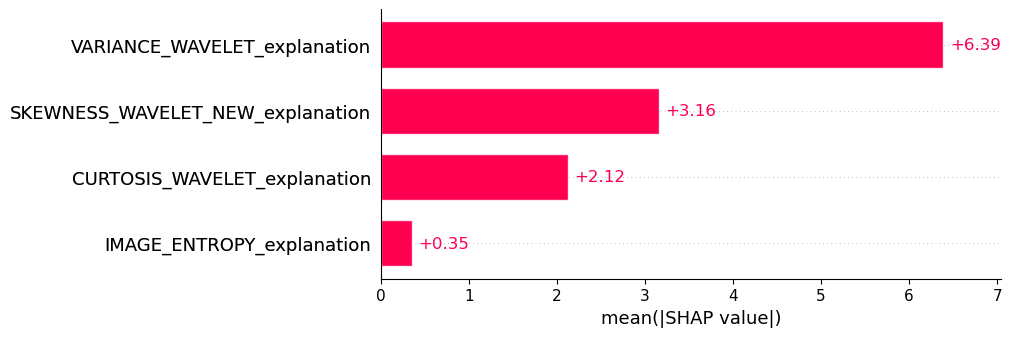

In [40]:
mv_explanations_pd_2 = mv_explanations_pd[['VARIANCE_WAVELET_explanation',
                                          'SKEWNESS_WAVELET_NEW_explanation', 
                                          'CURTOSIS_WAVELET_explanation',
                                            'IMAGE_ENTROPY_explanation']]

# Wrapping the explanations DataFrame into a SHAP recognized object
shap_exp = shap._explanation.Explanation(mv_explanations_pd_2.values, 
                                         feature_names = mv_explanations_pd_2.columns)
shap.plots.bar(shap_exp)

In [44]:
train_df.dtypes

[('VARIANCE_WAVELET', 'decimal(38,7)'),
 ('CURTOSIS_WAVELET', 'decimal(38,8)'),
 ('IMAGE_ENTROPY', 'decimal(38,7)'),
 ('CLASS', 'bigint'),
 ('SKEWNESS_WAVELET_NEW', 'double')]